# PyTorch three layer Convolutional Neural Network (CNN)
Now that you have implemented and understood all the necessary layers, we want to train a convolutional neural network. But training with our naive versions would not be feasible even for comparatively small networks. Since you already learned about losses, training procedures and solvers in the previous exercises we now want to introduce a modern deep learning framework called PyTorch (see `README.md` for installation help).

These frameworks facilitate network training and prototyping by providing useful helper functions and optimized versions of the most common layers and solvers. Check out the following links to make yourself familiar with PyTorch and how to implement a small network. Keep in mind the network graph structure discussed in the lecture.

http://pytorch.org/tutorials/

https://github.com/pytorch/examples

https://github.com/jcjohnson/pytorch-examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

from dl4cv.classifiers.cnn import ThreeLayerCNN
from dl4cv.data_utils import get_CIFAR10_data, OverfitSampler
from dl4cv.gradient_check import rel_error

#torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Train and validation data
For an easier management of the train and validation data pipelines we provide you with custom `torch.utils.data.Dataset` classes. Make yourself familiar with those `Dataset` classes as well as the `DataLoader` and how you have to integrate them in your training. The `num_workers` attribute allows you to preprocess data with multiple threads.

http://pytorch.org/docs/data.html

In [2]:
# Load the (preprocessed) CIFAR10 data. Preprocessing and dataset splitting is done
# as in 1_softmax.ipynb from exercise 1.
# This can take a while.

train_data, val_data, test_data, mean_image = get_CIFAR10_data()
print("Train size: %i" % len(train_data))
print("Val size: %i" % len(val_data))
print("Test size: %i" % len(test_data))

Train size: 48000
Val size: 1000
Test size: 1000


Img size: torch.Size([3, 32, 32])
Example image:


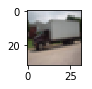

In [3]:
img, label = train_data[2]
print("Img size: " + str(img.size()))
plt.figure(figsize = (10,1))
print("Example image:")
plt.imshow(img.numpy().transpose(1,2,0) + mean_image.transpose(1,2,0))
plt.show()

## Model initialization and forward pass 

After you understood the core concepts of PyTorch and have a rough idea on how to implement your own model complete the initialization and forward methods of the `ThreeLayerCNN` in the `dl4cv/classifiers/cnn.py` file. Note that we do not have to implement a backward pass since this is automatically done by the framework using its dynamic graph structure.

Use the cell below to check your results.

In [4]:
from dl4cv.classifiers.cnn import ThreeLayerCNN

torch.manual_seed(0)
np.random.seed(0)

X = np.random.randn(2, 3, 5, 5).astype(np.float32)
X_tensor = torch.from_numpy(X.copy())
inputs = Variable(X_tensor)

model = ThreeLayerCNN(input_dim=(3, 5, 5), num_classes=3)
outputs = model.forward(inputs)
correct_outputs = np.array([[-0.012747,    0.05964366,  0.03898076],
                            [-0.01286934,  0.05963349,  0.03903975]])

# The difference should be very small. We get < 1e-6
print 'Difference between the correct and your forward pass:'
print rel_error(correct_outputs, outputs.data.numpy())

Difference between the correct and your forward pass:
0.907557864572


## Training and validation with the Solver
We train and validate our previously generated model with a seperate `Solver` class defined in `dl4cv/classifiers/solver.py`. Complete the training method and try to come up with an efficient iteration scheme as well as an informative training logger.

Use the cells below to test your solver. A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [5]:
from dl4cv.classifiers.cnn import ThreeLayerCNN
from dl4cv.classifiers.solver import Solver

num_train = 100
train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=False, num_workers=4,
                                           sampler=OverfitSampler(num_train))
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

overfit_model = ThreeLayerCNN()
overfit_solver = Solver(optim_args={"lr": 1e-2})
overfit_solver.train(overfit_model, train_loader, val_loader,  num_epochs=10,log_nth=1)

START TRAIN.
[Iteration 0/2] Train loss: 2.3126
[Iteration 1/2] Train loss: 5.5065
[Epoch 0/10] Train acc/loss: 0.1200/5.5065
[Epoch 0/10] Val acc/loss: 0.1150/3.4676
[Iteration 0/2] Train loss: 3.3400
[Iteration 1/2] Train loss: 3.1495
[Epoch 1/10] Train acc/loss: 0.0800/3.1495
[Epoch 1/10] Val acc/loss: 0.1290/3.0007
[Iteration 0/2] Train loss: 3.2007
[Iteration 1/2] Train loss: 2.1822
[Epoch 2/10] Train acc/loss: 0.2600/2.1822
[Epoch 2/10] Val acc/loss: 0.1860/2.2316
[Iteration 0/2] Train loss: 2.2307
[Iteration 1/2] Train loss: 1.9677
[Epoch 3/10] Train acc/loss: 0.3400/1.9677
[Epoch 3/10] Val acc/loss: 0.1830/2.0889
[Iteration 0/2] Train loss: 1.8332
[Iteration 1/2] Train loss: 1.5916
[Epoch 4/10] Train acc/loss: 0.4200/1.5916
[Epoch 4/10] Val acc/loss: 0.2170/2.3003
[Iteration 0/2] Train loss: 1.5679
[Iteration 1/2] Train loss: 1.4227
[Epoch 5/10] Train acc/loss: 0.5800/1.4227
[Epoch 5/10] Val acc/loss: 0.1970/2.5354
[Iteration 0/2] Train loss: 1.2700
[Iteration 1/2] Train loss: 

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

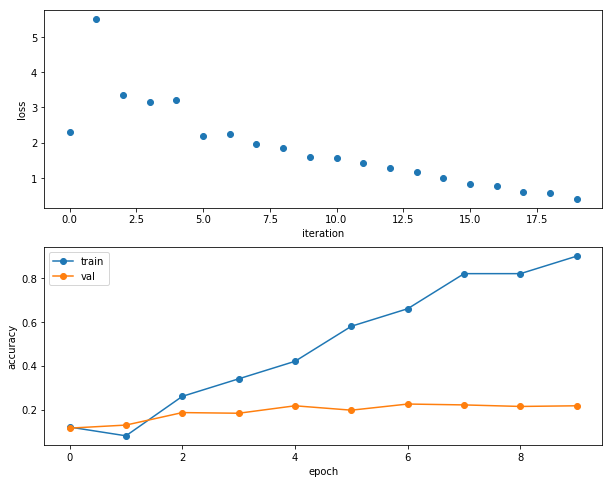

In [6]:
plt.subplot(2, 1, 1)
plt.plot(overfit_solver.train_loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(overfit_solver.train_acc_history, '-o')
plt.plot(overfit_solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the validation set.

In [7]:
from dl4cv.classifiers.cnn import ThreeLayerCNN
from dl4cv.classifiers.solver import Solver

train_loader = torch.utils.data.DataLoader(train_data, batch_size=50, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50, shuffle=False, num_workers=4)

############################################################################
# TODO: Train your network and find the best hyperparameters               #
############################################################################

        
model = ThreeLayerCNN(hidden_dim=500)
solver = Solver(optim_args={"lr": 1e-3, "weight_decay": 0.001})
solver.train(model, train_loader, val_loader, log_nth=100, num_epochs=3)

START TRAIN.
[Iteration 99/960] Train loss: 1.8289
[Iteration 199/960] Train loss: 1.6656
[Iteration 299/960] Train loss: 1.4267
[Iteration 399/960] Train loss: 1.4825
[Iteration 499/960] Train loss: 1.2262
[Iteration 599/960] Train loss: 1.3679
[Iteration 699/960] Train loss: 1.6938
[Iteration 799/960] Train loss: 1.2366
[Iteration 899/960] Train loss: 1.1265
[Epoch 0/3] Train acc/loss: 0.6000/1.1277
[Epoch 0/3] Val acc/loss: 0.5610/1.0757
[Iteration 99/960] Train loss: 1.2370
[Iteration 199/960] Train loss: 1.0462
[Iteration 299/960] Train loss: 1.1605
[Iteration 399/960] Train loss: 0.9084
[Iteration 499/960] Train loss: 1.1562
[Iteration 599/960] Train loss: 1.0015
[Iteration 699/960] Train loss: 1.2098
[Iteration 799/960] Train loss: 0.9453
[Iteration 899/960] Train loss: 1.3110
[Epoch 1/3] Train acc/loss: 0.6800/0.9399
[Epoch 1/3] Val acc/loss: 0.6200/0.7473
[Iteration 99/960] Train loss: 0.9315
[Iteration 199/960] Train loss: 1.0810
[Iteration 299/960] Train loss: 1.1561
[Iterat

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following. If your kernel visualizations do not exhibit clear structures try optimizing the weight scale:

In [8]:
from dl4cv.vis_utils import visualize_grid

conv_params = model.conv.weight.data.numpy()
grid = visualize_grid(conv_params.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(6, 6)
plt.show()

AttributeError: 'ThreeLayerCNN' object has no attribute 'conv'

# Test your model
Run your best model on the validation and test sets. You should achieve above 58% accuracy on the test set.

In [9]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50, shuffle=False, num_workers=4)

scores = []
for batch in test_loader:
    inputs, labels = Variable(batch[0]), Variable(batch[1])

    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    scores.extend((preds == labels).data.numpy())
    
print 'Test set accuracy: %f' % np.mean(scores)

Test set accuracy: 0.633000


## Save the model

When you are satisfied with your training, save the model for submission.

In [10]:
model.save("models/three_layer_cnn.model")

Saving model... models/three_layer_cnn.model


## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.58 \\
        \left(\frac{58}{\exp(0.58 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.58 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

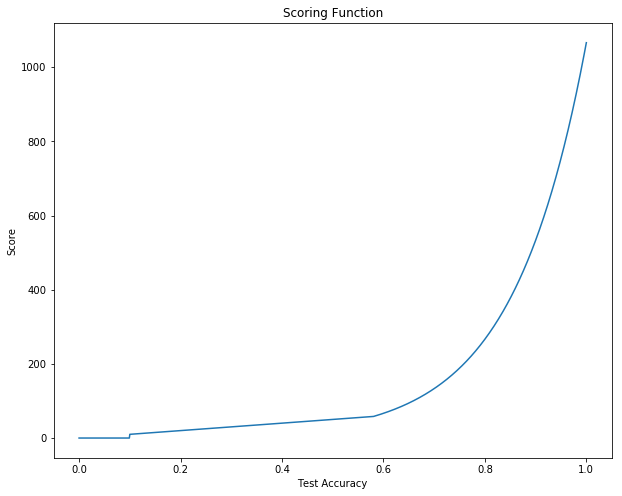

In [11]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.58, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()